### Environment

In [126]:
import numpy as np

class HunterEnvironment:
    def __init__(self,victim_policy,target_distance = 2,distance_accuracy = 1, victim_position=0, hunter_position = [0,0]):
        self.observation_space = 6
        self.action_space = 2
        self.distance_accuracy = distance_accuracy
        self.target_distance = target_distance
        self.victim_policy = victim_policy
        
        # if None - get random position on elipse
        if victim_position is None:
            self.time = np.random.randint(1000)
        else:
            self.time = victim_position
            
        self.victim_position = np.array(self.victim_policy(self.time ))
        self.time += 1
        
        self.hunter_position = np.array(hunter_position)
        self.initial_victim_position = self.victim_position
        self.initial_hunter_position = self.hunter_position
        self.hunter_shift = np.array([0, 0])
        self.hunter_trajectory = []
        self.victim_trajectory = []
        self.distance = np.linalg.norm(self.victim_position-self.hunter_position)
        

    def step(self, hunter_shift):
        hunter_shift = np.array(hunter_shift)
        self.update_positions(hunter_shift)
        self.update_state()
        reward = self.get_reward()
        return reward
    
    def get_reward(self):
        if self.is_hunter_on_target_distance:
            reward = 1
        elif self.is_hunter_closer:
            reward = 0
        else:
            reward = -1
        return reward
        
        
    def update_positions(self,hunter_shift):
        #hunter
        self.hunter_shift = hunter_shift
        self.hunter_position = self.hunter_position+hunter_shift
        self.hunter_trajectory.append(self.hunter_position)
        # victim
        new_victim_position = self.victim_policy(self.time)
        self.victim_shift = new_victim_position-self.victim_position
        self.victim_position = new_victim_position
        self.victim_trajectory.append(self.victim_position)
        
        self.time +=1
    
    def update_state(self):
        new_distance = np.linalg.norm(self.victim_position-self.hunter_position)
        is_hunter_closer = new_distance<self.distance
        is_hunter_on_target_distance = abs(new_distance-self.target_distance)<self.distance_accuracy
        self.distance = new_distance
        normalized_victim_shift = self.victim_shift/np.linalg.norm(self.victim_shift)
        
        
        self.is_hunter_closer = is_hunter_closer
        self.is_hunter_on_target_distance = is_hunter_on_target_distance
        self.state = [is_hunter_closer,is_hunter_on_target_distance,
                      normalized_victim_shift,self.hunter_shift]
        
        
    def reset(self):
        
        self.__init__(victim_policy=self.victim_policy, target_distance=self.target_distance, 
                      distance_accuracy=self.distance_accuracy, victim_position=None,
                      hunter_position=self.initial_hunter_position)
        
        flip = np.random.uniform()
        if flip<1/2:
            v = np.random.uniform(-1, 1, size=2)
            v = v/np.linalg.norm(v)
            self.hunter_position = self.victim_position + v*self.target_distance
            self.state = [False,True,np.array([0.,0.]),np.array([0.,0.])]
        else:
            self.state = [False,False,np.array([0.,0.]),np.array([0.,0.])]
            v = np.random.uniform(-1, 1, size=2)
            self.hunter_position = self.victim_position +v*(self.target_distance+2)

        self.hunter_trajectory = [self.hunter_position]
        self.victim_trajectory = [self.victim_position]

        
def simple_victim_policy(t):
    phi = (2*np.pi)/30*t*0.1
    r = 10+2*np.sin(phi*2)**2*0

    x = r * np.sin(phi)#+(t/20)
    y = r * np.cos(phi)#+(t/10)
    return np.array([x,y])

env = HunterEnvironment(simple_victim_policy)
env.reset()

### Hunter policy

### Policy distribution

Since hunter may moove only with speed constrained by some constant, we need to
constrain action space. Let's define max speed as $v_{max}$.
We may define our distribution via some function $G(x)$ from simple normal distribution $\mathcal{N}(x|\mu,diag(e^{2 s}))$.
Let's define function $g(x)$ so, that it was constrained in circle with radius $v_{max}$:
$$
G(x) = v_{max}\frac{x}{||x||_2}e^{-||x||_2^2} 
$$

$$\nabla_x\left[\textbf{f}(x)g(x)\right] = \frac{d\textbf{f}(x)}{dx}g(x)+\frac{dg(x)}{dx} \textbf{f}(x)^T $$

$$ \nabla_x G(x) =v_{max} \left( \frac{e^{-||x||_2^2}}{||x||_2} I + \nabla_x\left[\frac{e^{-||x||_2^2}}{||x||_2}\right]x^T\right) $$

$$ \nabla_x\left[\frac{e^{-||x||_2^2}}{||x||_2}\right] = \nabla_{||x||_2}\left[\frac{e^{-||x||_2^2}}{||x||_2}\right]\nabla_x||x||_2$$

$$\nabla_x||x||_2 = \frac{x}{||x||_2}$$
$$  \nabla_{||x||_2}\left[\frac{e^{-||x||_2^2}}{||x||_2}\right] = -\left[\frac{1}{||x||_2^2}+2\right]e^{-||x||_2^2}$$

$$ \nabla_x G(x) =v_{max}\frac{e^{-||x||_2^2}}{||x||_2} \left(I -\left[\frac{1}{||x||_2^2}+2\right] x x^T\right)  $$

$$\mathcal{J}_{G(x)}=-\left(v_{max} \frac{e^{-||x||_2^2}}{||x||_2}\right)^n \left(1-\left[\frac{1}{||x||_2^2}+2\right]||x||_2^2 \right) = 2\left(v_{max} \frac{e^{-||x||_2^2}}{||x||_2}\right)^n ||x||_2^2 $$

for 2 dimentions:
$$\mathcal{J}_{G(x)}=2 v_{max}^2 e^{-2||x||_2^2}$$

$$\ln(\mathcal{J}_{G(x)}^{-1})=2\left(||x||_2^2-\ln v_{max}\right)-\ln 2$$

So, PDF of distribution rv G(x) may be estimated as following:
$$\mathcal{N}(x|\mu,diag(e^{2s}))J_{G(x)}^{-1}$$

In [127]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Normal
%matplotlib inline


In [128]:
#Hyperparameters
learning_rate = 0.0001
gamma = 0.9
class HunterPolicy(nn.Module):
    def __init__(self,max_speed = 1):
        super(HunterPolicy, self).__init__()
        self.max_speed = max_speed
        self.state_space = env.observation_space
        self.action_space = env.action_space


        
        self.l1 = nn.Linear(self.state_space, 128)
        self.l2 = nn.Linear(128, 128)
        self.l3 = nn.Linear(128, self.action_space*2)
        
        self.gamma = gamma
        
        # Episode policy and reward history 
        self.policy_history = torch.Tensor()
        self.reward_episode = []
        # Overall reward and loss history
        self.reward_history = []
        self.loss_history = []
        
    def get_action(self,latent_action):
        action = self.max_speed*latent_action/torch.norm(latent_action)*torch.exp(-(latent_action**2).sum())
        return action
    
    def get_log_jacobian(self,latent_action):
        return 2*((latent_action**2).sum()-np.log(self.max_speed))-np.log(2)
        
    def log_prob(self,latent_action):
        latent_log_prob = self.latent_action_dist.log_prob(latent_action).sum(dim = -1)
        log_jacobian = self.get_log_jacobian(latent_action)
        log_prob = latent_log_prob+log_jacobian
        return log_prob
    
    def sample_action(self):
        latent_action = self.latent_action_dist.sample()
        action = self.get_action(latent_action)
        return action, self.log_prob(latent_action)
        
    def forward(self, state):    
            model = torch.nn.Sequential(
                self.l1,
                nn.ELU(),
                self.l2,
                nn.ELU(),
                self.l3
            )

            output = model(torch.FloatTensor(np.hstack(state)))
            mu,logsigma = torch.chunk(output,2)
            self.latent_action_dist = Normal(mu,(2*logsigma).exp())
            return mu,logsigma
        
policy = HunterPolicy()
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
policy([True,False,[1.1,0],[1.1,0]])


(tensor([ 0.3355, -0.0748], grad_fn=<SplitBackward>),
 tensor([0.0462, 0.2635], grad_fn=<SplitBackward>))

In [129]:
def select_action(state):
    #Select an action (0 or 1) by running policy model and choosing based on the probabilities in state
    
    state_mu,state_logsigma = policy(state)
    action,log_prob = policy.sample_action()
    # Add log probability of our chosen action to our history    
    if policy.policy_history.dim() != 0:
        policy.policy_history = torch.cat([policy.policy_history, log_prob.unsqueeze(0)])
    else:
        policy.policy_history = (log_prob.unsqueeze(0))
    return action

In [130]:
def update_policy():
    R = 0
    rewards = []
    
    # Discount future rewards back to the present using gamma
    for r in (policy.reward_episode[::-1]):
        R = r + policy.gamma * R
        rewards.insert(0,R)
    # Scale rewards
    rewards = torch.FloatTensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std())
    
    # Calculate loss
    loss = (torch.sum(torch.mul(policy.policy_history, rewards).mul(-1), -1))
    # Update network weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #Save and intialize episode history counters
    policy.loss_history.append(loss.data[0])
    policy.reward_history.append(np.sum(policy.reward_episode))
    policy.policy_history = torch.Tensor()
    policy.reward_episode= []

In [131]:
import matplotlib.pyplot as plt
%matplotlib inline

import torch, torch.nn as nn

import time 
from IPython import  display

def main(episodes, verbose=True):
    running_reward = 10
    for episode in range(episodes):
        env.reset() # Reset environment and record the starting state
        state = env.state
        done = False       
    
        for time in range(1000):
            action = select_action(state)
            # Step through environment using chosen action
            hunter_shift = action
            reward = env.step(hunter_shift)
            state = env.state
            # Save reward
            policy.reward_episode.append(reward)
        
        
        
        update_policy()
        
        if verbose and episode % 10 == 0:
            
            display.clear_output(wait=True)

            plt.figure(figsize=(16, 6))
            plt.subplot(221)
            plt.title("reward")
            plt.xlabel("#iteration")
            plt.ylabel("reward")
            plt.plot(policy.reward_history, label = 'reward')
            plt.subplot(222)
            victim = np.array(env.victim_trajectory).T
            plt.plot(victim[0],victim[1], label = 'victim')
            plt.plot(victim[0][0], victim[1][0], 'o', label = 'initiial_victim')
            hunter = np.array(env.hunter_trajectory).T
            plt.plot(hunter[0], hunter[1], label = 'hunter')
            plt.plot(hunter[0][0], hunter[1][0], 'o', label = 'initiial_hunter')
            plt.legend()
           
        
            plt.show()
        
            print('Episode {}\tLast length: {:5d}\tLast reward: {:.2f}'.format(episode, time, policy.reward_history[-1]))


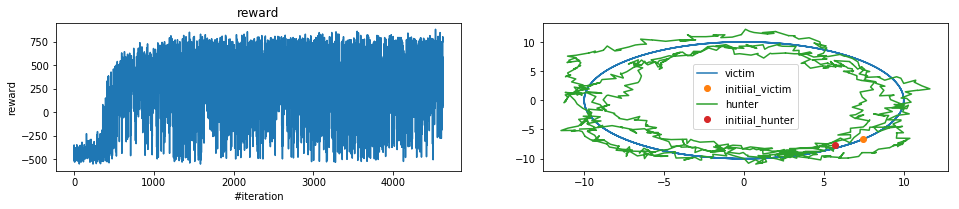

Episode 3020	Last length:   999	Last reward: 749.00


KeyboardInterrupt: 

In [133]:
optimizer = optim.Adam(policy.parameters(), lr=learning_rate/10)
policy.gamma = 0.9
main(100000)

In [ ]:
policy.gamma = 0.9
main(100000)

In [120]:
torch.save(policy,'policy_speed_1.p')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type HunterPolicy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [138]:
policy = torch.load('policy_speed_3.p')

### Test Visualization

In [145]:
# Event distance between victim and hunter reduced and victim, hunter velocities are known

%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from time import sleep

def create_graph(name):
    plt.ion()
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111)
    ax.set_title(name,fontsize=30)
    hunter_line, = ax.plot(0, 0, 'r-',label = 'Hunter trajectory')
    hunter_position_point, = ax.plot(0, 0, 'r*',label = 'Hunter position')
    victim_line, = ax.plot(0, 0, 'g-',label = 'Victim trajectory')
    victim_position_point, = ax.plot(0, 0, 'g*',label = 'Victim position')
    
    ax.legend()
    graph = (hunter_line,hunter_position_point,victim_line,victim_position_point),fig, ax
    return graph

def update_graph(graph,hunter_trajectoty,victim_trajectoty):
    (hunter_line,hunter_position_point,victim_line,victim_position_point),fig, ax = graph
    x = np.r_[hunter_trajectoty[0],victim_trajectoty[0]]
    y = np.r_[hunter_trajectoty[1],victim_trajectoty[1]]
    ax.set_xlim(x.min(),x.max())
    ax.set_ylim(y.min(),y.max())
    hunter_line.set_data(*hunter_trajectoty)
    hunter_position_point.set_data(*hunter_trajectoty.T[-1])
    victim_line.set_data(*victim_trajectoty)
    victim_position_point.set_data(*victim_trajectoty.T[-1])
    fig.canvas.draw()

    
def model_hunter_learnong(name,hunter_policy,victim_policy,hunter_start_position = [0,0]):
    graph = create_graph(name)
    env = HunterEnvironment(victim_policy)
    env.step(hunter_start_position)
    state = env.state
    for _  in range(1000):
        policy(state)
        action,_ = policy.sample_action()
        hunter_shift = action
        env.step(hunter_shift)
        state = env.state
        update_graph(graph,np.array(env.hunter_trajectory).T,np.array(env.victim_trajectory).T)
            
        




<IPython.core.display.Javascript object>


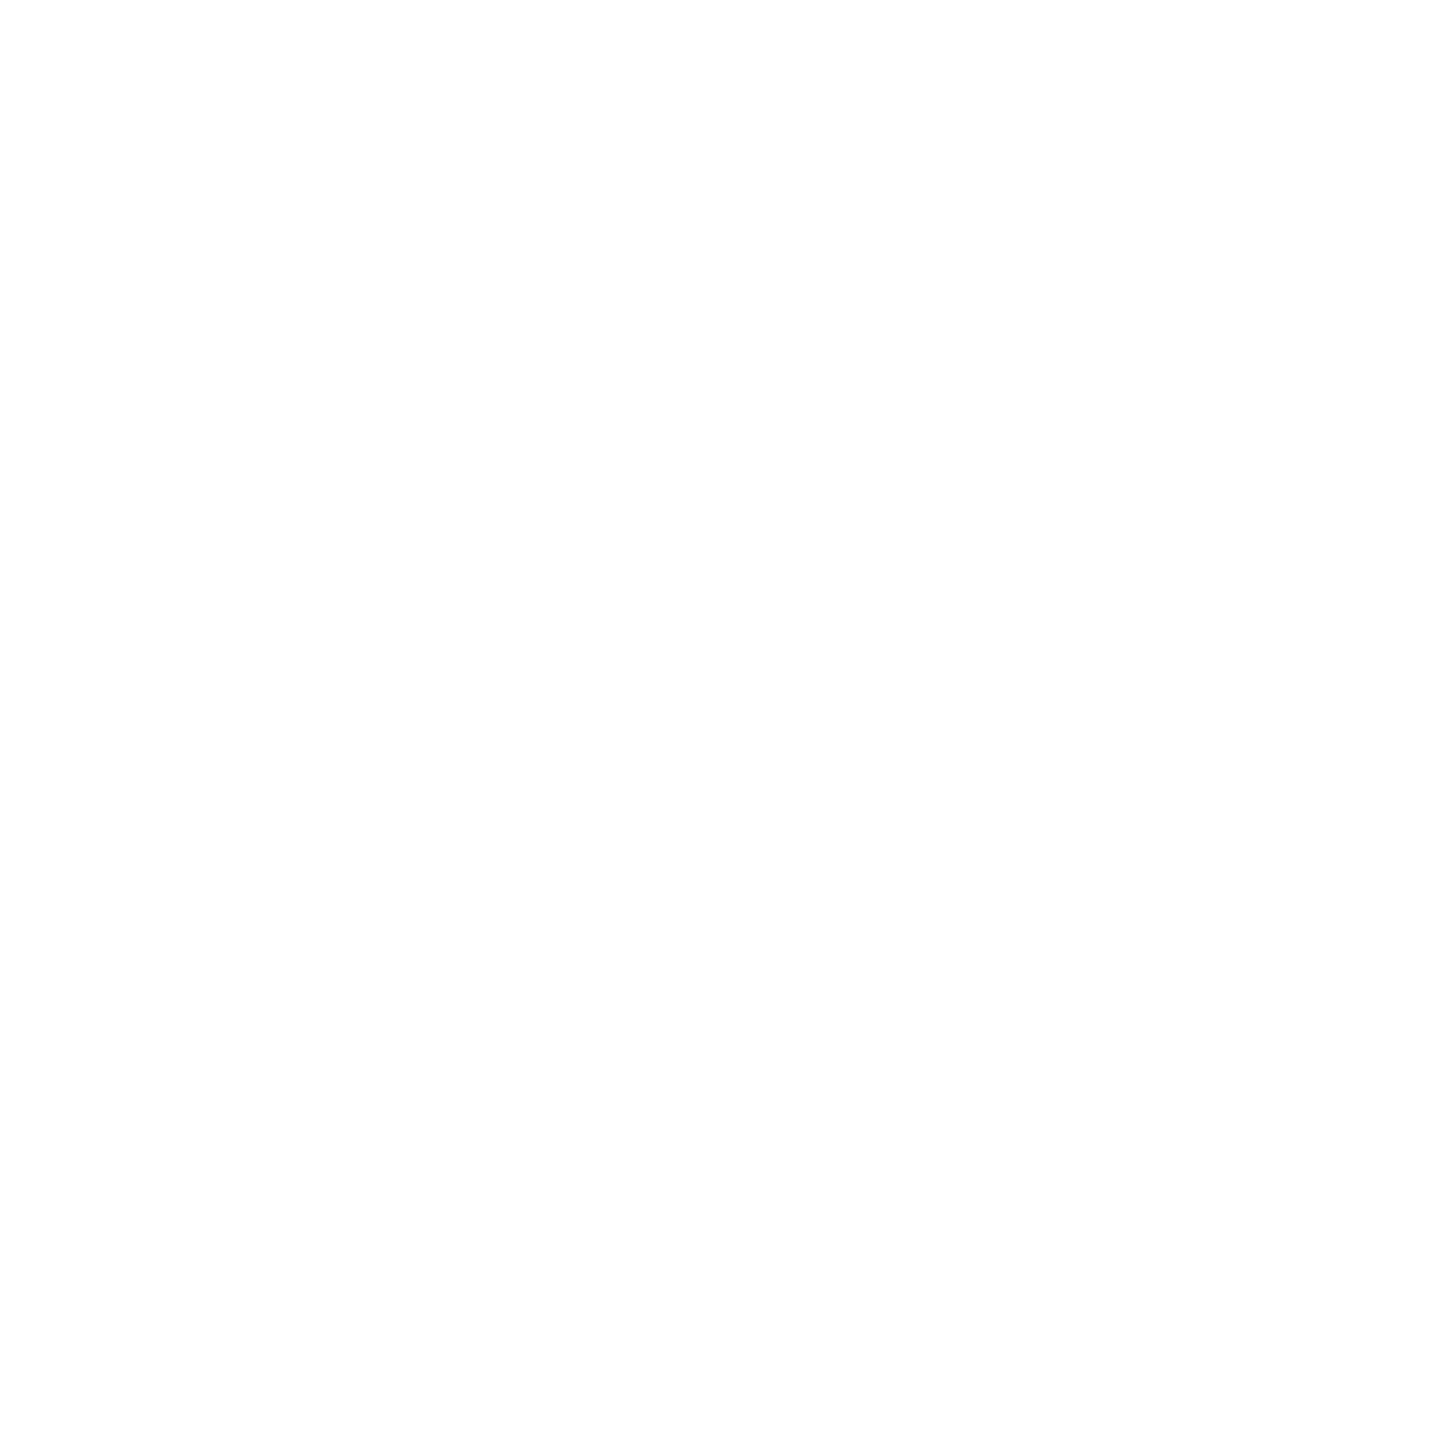

<IPython.core.display.Javascript object>


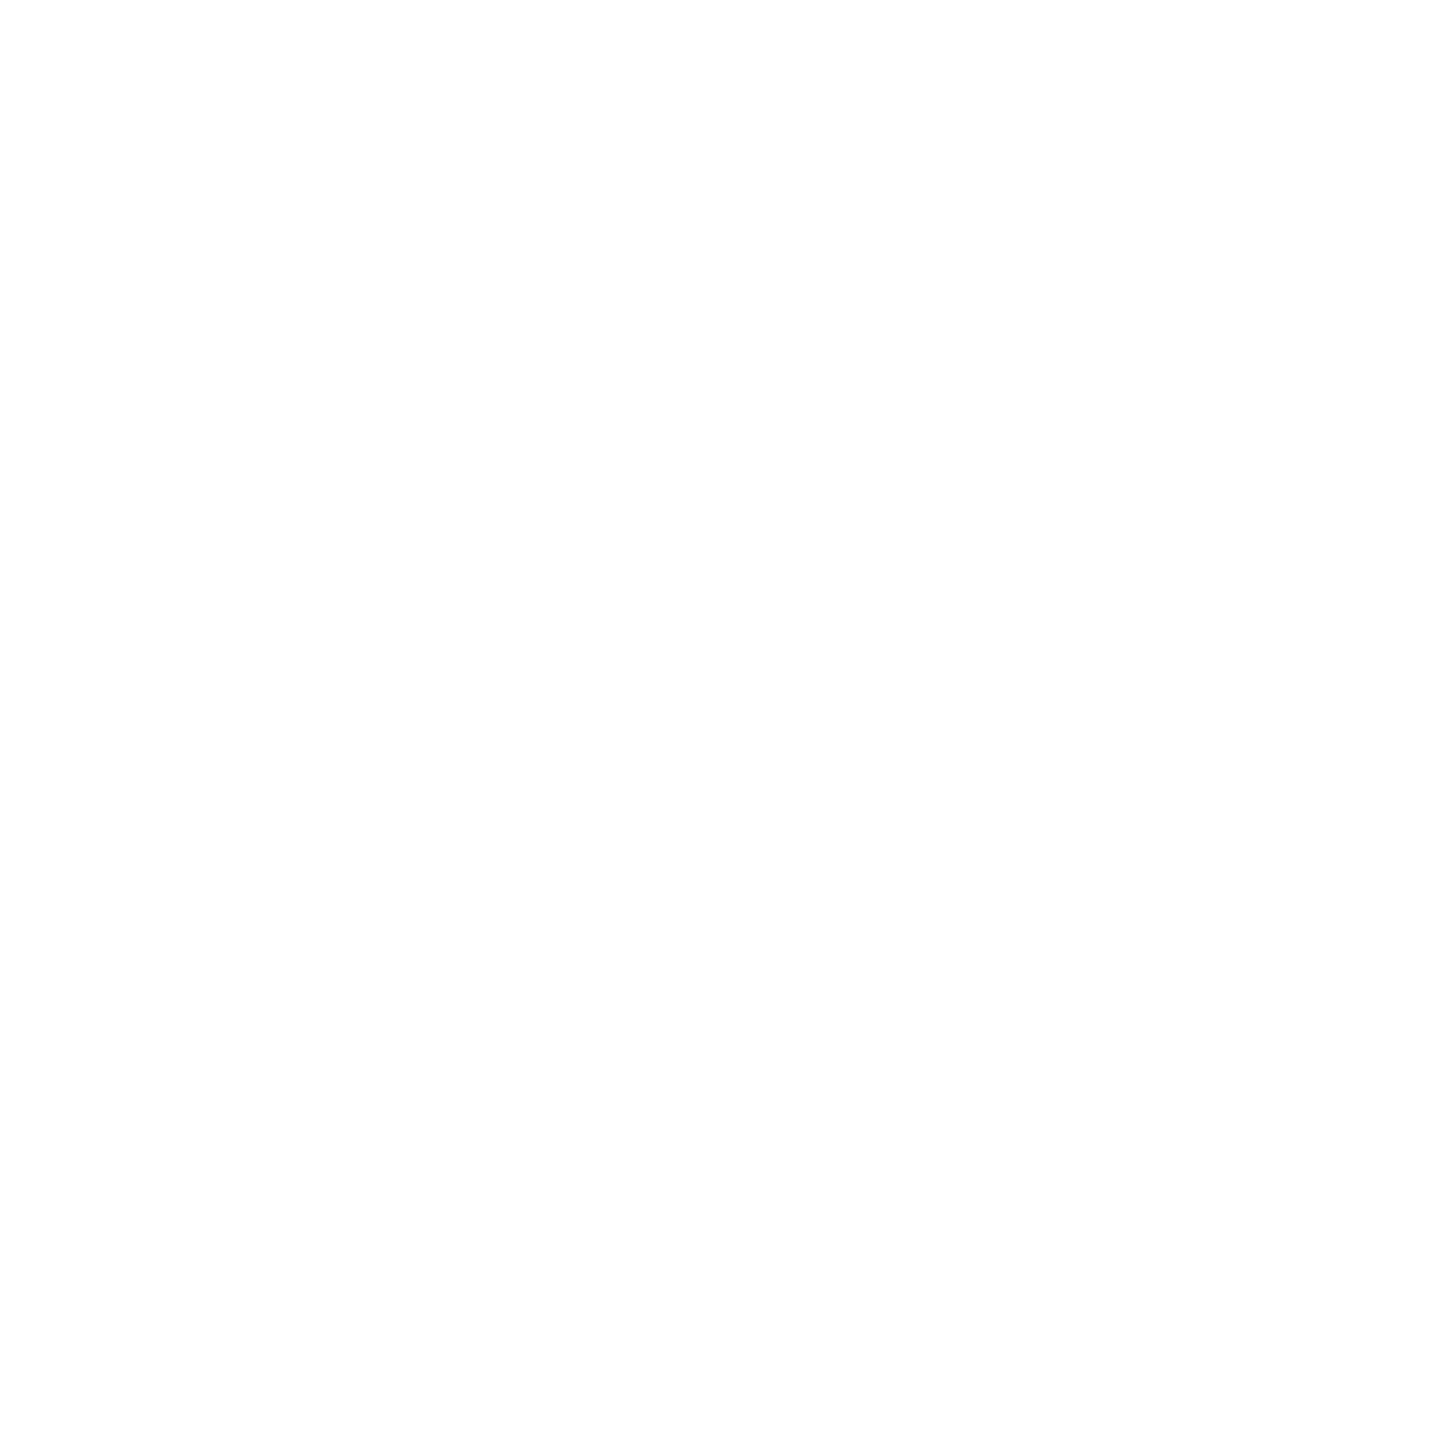

In [148]:
# %matplotlib inline
model_hunter_learnong('Test. max speed = 3',policy,simple_victim_policy,hunter_start_position=[20,20])